In [27]:
import os
import numpy as np
import pandas as pd
import librosa
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from transformers import AutoModelForSequenceClassification, AutoTokenizer, Trainer, TrainingArguments
import torch
import torch.nn as nn
from torchviz import make_dot
from torchsummary import summary

In [28]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
os.environ['TORCH_USE_CUDA_DSA'] = "1"


In [29]:
# data_dir="C:/Users/divya/OneDrive/Documents/UTAUSTIN/Semester 6/460j/final_project_data/fma_small"
# file_path="C:/Users/divya/OneDrive/Documents/UTAUSTIN/Semester 6/460j/final_project_data/fma_small/000/000002.mp3"
train_path = 'C:/Users/divya/OneDrive/Documents/UTAUSTIN/Semester6/460j/460jFinalProject/csvfiles/extracted_features_combined.csv'
# train_path = 'C:/Users/divya/OneDrive/Documents/UTAUSTIN/Semester6/460j/460jFinalProject/csvfiles/extracted_features_wav2vec.csv'
torch.manual_seed(42)

data_df=pd.read_csv(train_path, index_col=0)
# data_df=pd.read_csv(train_path)


In [30]:


# Assuming data_df is your DataFrame containing features and genre labels
X = StandardScaler().fit_transform(data_df.drop('genre', axis=1))
genres = data_df['genre'].unique()
binary_labels = {genre: (data_df['genre'] == genre).astype(int) for genre in genres}


In [31]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device=torch.device("cpu")
print("Using device:", device)

Using device: cuda


In [32]:
from torch.utils.data import DataLoader, TensorDataset, random_split
import torch
def create_loaders(X, y, batch_size=32):
    """ Create DataLoaders for training and testing datasets """
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    # Convert to tensors and move to the device
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
    y_train_tensor = torch.tensor(y_train, dtype=torch.long).to(device)
    y_test_tensor = torch.tensor(y_test, dtype=torch.long).to(device)
    
    # Creating datasets and loaders
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    return train_loader, test_loader



In [33]:
class MLP(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(MLP, self).__init__()
        self.layers = nn.Sequential(
            nn.BatchNorm1d(input_dim),
            nn.Linear(input_dim, 2048),
            nn.BatchNorm1d(2048),
            nn.LeakyReLU(),
            nn.Dropout(0.1),
            nn.Linear(2048, 1024),
            nn.LeakyReLU(),
            nn.Dropout(0.1),
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(),
            nn.Dropout(0.1),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(),
            nn.Linear(128,out_features=output_dim)

        )
        
    def forward(self, x):
        return self.layers(x)


In [34]:
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

def train_model(model, train_loader, test_loader, device, epochs=100,lr=0.00051):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    accuracies = []  # List to store accuracy for each epoch
    
    for epoch in range(epochs):
        model.train()
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            # print("Input shape:", inputs.shape)  # Debug input shape

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        model.eval()
        total = correct = 0
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        accuracy = 100 * correct / total
        accuracies.append(accuracy)  # Store accuracy for this epoch

        print(f'Epoch {epoch+1}: Accuracy: {accuracy}%')

    # Plotting the accuracies
    plt.figure(figsize=(20, 5))
    plt.plot(range(1, epochs+1), accuracies, marker='o', linestyle='-')
    plt.title('Accuracy vs. Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.grid(True)
    plt.xticks(range(1, epochs+1))  # Ensure x-axis labels match epoch numbers
    plt.yticks(range(0, 101, 10))  # Setting y-axis labels from 0 to 100% with steps of 10%
    plt.show()

    return max(accuracies)  # Return the highest accuracy reached


Epoch 1: Accuracy: 86.2442684451855%
Epoch 2: Accuracy: 86.53605669028762%
Epoch 3: Accuracy: 87.49478949562318%
Epoch 4: Accuracy: 88.5368903709879%
Epoch 5: Accuracy: 87.16131721550646%
Epoch 6: Accuracy: 87.61984160066694%
Epoch 7: Accuracy: 88.41183826594414%
Epoch 8: Accuracy: 88.5368903709879%
Epoch 9: Accuracy: 88.12005002084202%
Epoch 10: Accuracy: 89.07878282617757%
Epoch 11: Accuracy: 87.95331388078365%
Epoch 12: Accuracy: 88.07836598582743%
Epoch 13: Accuracy: 88.16173405585661%
Epoch 14: Accuracy: 88.16173405585661%
Epoch 15: Accuracy: 89.49562317632346%
Epoch 16: Accuracy: 87.95331388078365%
Epoch 17: Accuracy: 88.5368903709879%
Epoch 18: Accuracy: 88.32847019591496%
Epoch 19: Accuracy: 87.49478949562318%
Epoch 20: Accuracy: 88.91204668611921%
Epoch 21: Accuracy: 88.49520633597332%
Epoch 22: Accuracy: 88.70362651104627%
Epoch 23: Accuracy: 88.74531054606086%
Epoch 24: Accuracy: 88.62025844101709%
Epoch 25: Accuracy: 89.28720300125052%
Epoch 26: Accuracy: 88.24510212588578%

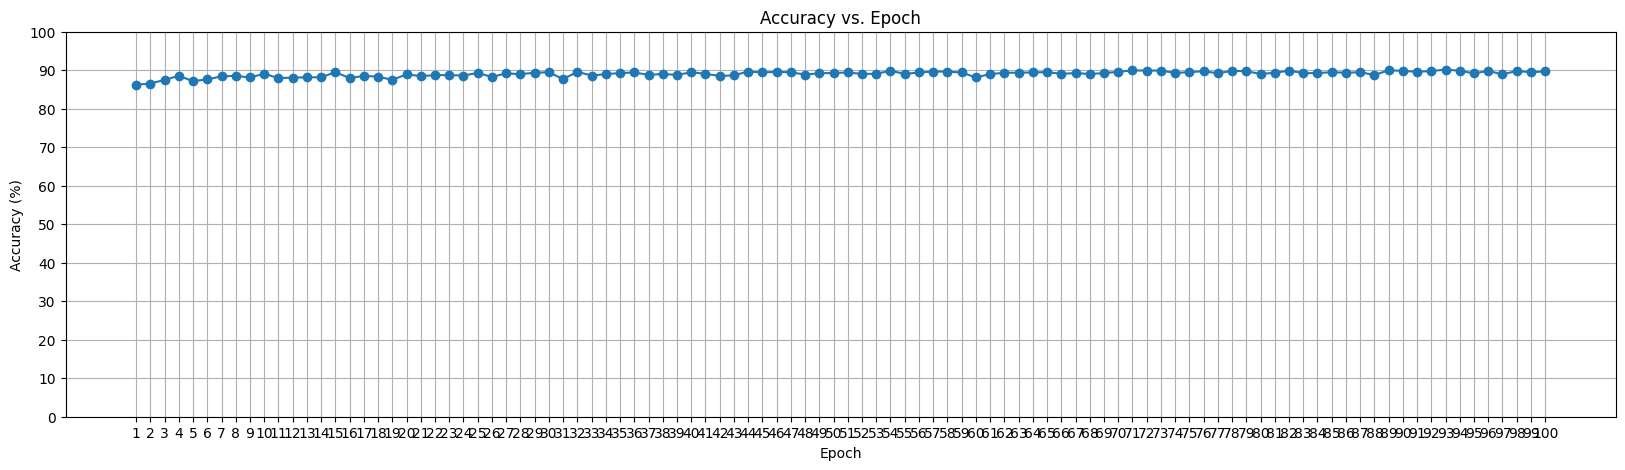

Epoch 1: Accuracy: 88.24510212588578%
Epoch 2: Accuracy: 88.24510212588578%
Epoch 3: Accuracy: 88.24510212588578%
Epoch 4: Accuracy: 88.24510212588578%
Epoch 5: Accuracy: 88.24510212588578%
Epoch 6: Accuracy: 88.24510212588578%
Epoch 7: Accuracy: 88.37015423092956%
Epoch 8: Accuracy: 88.24510212588578%
Epoch 9: Accuracy: 88.28678616090038%
Epoch 10: Accuracy: 88.45352230095874%
Epoch 11: Accuracy: 88.28678616090038%
Epoch 12: Accuracy: 88.28678616090038%
Epoch 13: Accuracy: 88.24510212588578%
Epoch 14: Accuracy: 88.32847019591496%
Epoch 15: Accuracy: 88.32847019591496%
Epoch 16: Accuracy: 88.70362651104627%
Epoch 17: Accuracy: 88.66194247603168%
Epoch 18: Accuracy: 88.12005002084202%
Epoch 19: Accuracy: 83.78491037932471%
Epoch 20: Accuracy: 88.16173405585661%
Epoch 21: Accuracy: 88.03668195081283%
Epoch 22: Accuracy: 88.03668195081283%
Epoch 23: Accuracy: 87.82826177573989%
Epoch 24: Accuracy: 88.24510212588578%
Epoch 25: Accuracy: 88.24510212588578%
Epoch 26: Accuracy: 87.49478949562

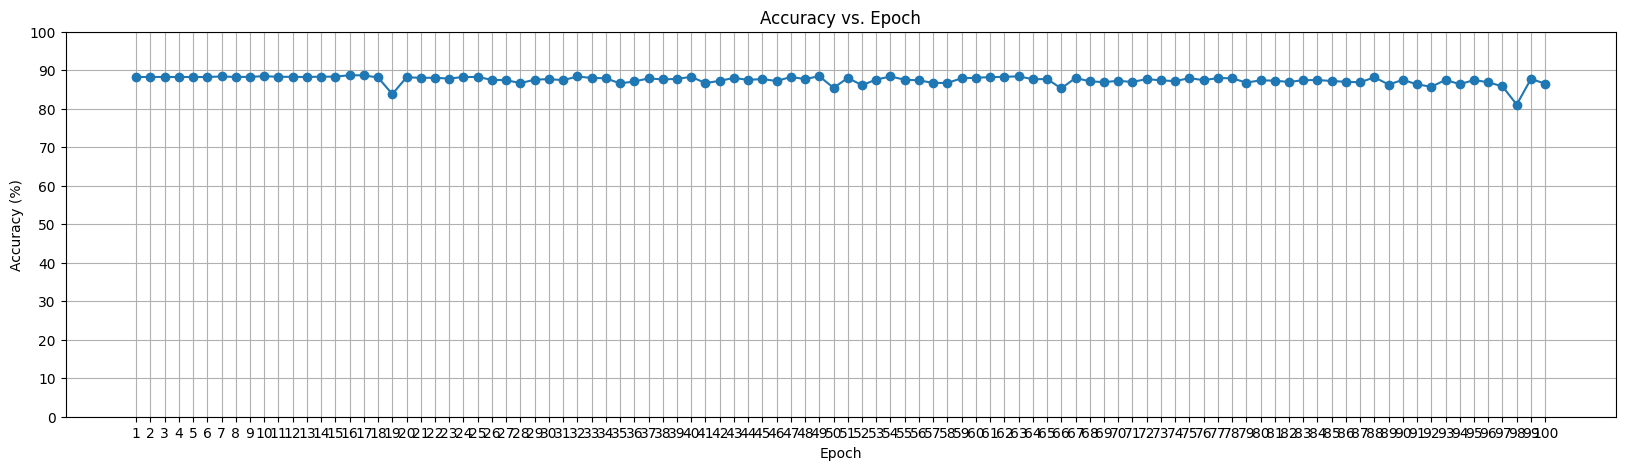

Epoch 1: Accuracy: 87.11963318049187%
Epoch 2: Accuracy: 88.41183826594414%
Epoch 3: Accuracy: 87.95331388078365%
Epoch 4: Accuracy: 88.16173405585661%
Epoch 5: Accuracy: 88.70362651104627%
Epoch 6: Accuracy: 88.12005002084202%
Epoch 7: Accuracy: 89.3705710712797%
Epoch 8: Accuracy: 87.32805335556482%
Epoch 9: Accuracy: 88.32847019591496%
Epoch 10: Accuracy: 88.62025844101709%
Epoch 11: Accuracy: 88.82867861609003%
Epoch 12: Accuracy: 89.12046686119217%
Epoch 13: Accuracy: 84.95206335973322%
Epoch 14: Accuracy: 88.82867861609003%
Epoch 15: Accuracy: 89.03709879116299%
Epoch 16: Accuracy: 84.86869528970405%
Epoch 17: Accuracy: 88.95373072113381%
Epoch 18: Accuracy: 89.49562317632346%
Epoch 19: Accuracy: 89.745727386411%
Epoch 20: Accuracy: 89.28720300125052%
Epoch 21: Accuracy: 89.24551896623593%
Epoch 22: Accuracy: 88.5785744060025%
Epoch 23: Accuracy: 89.24551896623593%
Epoch 24: Accuracy: 89.03709879116299%
Epoch 25: Accuracy: 87.86994581075449%
Epoch 26: Accuracy: 89.20383493122134%

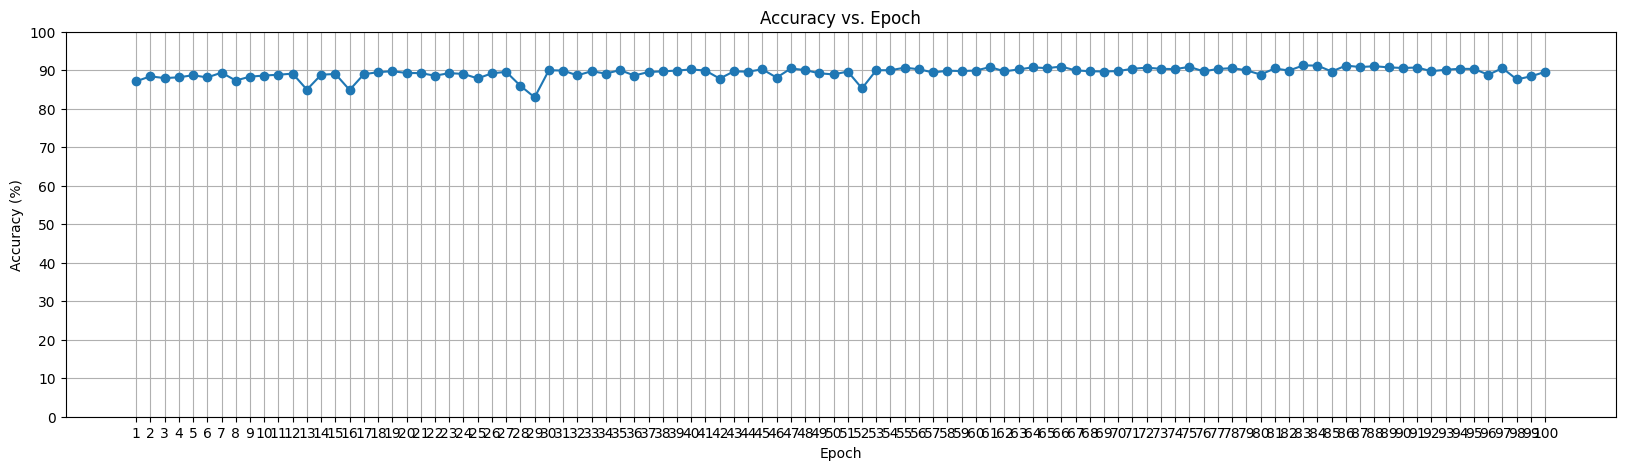

Epoch 1: Accuracy: 87.99499791579825%
Epoch 2: Accuracy: 88.45352230095874%
Epoch 3: Accuracy: 88.32847019591496%
Epoch 4: Accuracy: 87.411421425594%
Epoch 5: Accuracy: 87.99499791579825%
Epoch 6: Accuracy: 87.99499791579825%
Epoch 7: Accuracy: 88.24510212588578%
Epoch 8: Accuracy: 88.62025844101709%
Epoch 9: Accuracy: 84.86869528970405%
Epoch 10: Accuracy: 88.07836598582743%
Epoch 11: Accuracy: 88.95373072113381%
Epoch 12: Accuracy: 88.5785744060025%
Epoch 13: Accuracy: 88.37015423092956%
Epoch 14: Accuracy: 88.32847019591496%
Epoch 15: Accuracy: 88.70362651104627%
Epoch 16: Accuracy: 88.24510212588578%
Epoch 17: Accuracy: 86.82784493538975%
Epoch 18: Accuracy: 88.45352230095874%
Epoch 19: Accuracy: 88.2034180908712%
Epoch 20: Accuracy: 87.45310546060858%
Epoch 21: Accuracy: 87.53647353063776%
Epoch 22: Accuracy: 88.28678616090038%
Epoch 23: Accuracy: 88.49520633597332%
Epoch 24: Accuracy: 88.5368903709879%
Epoch 25: Accuracy: 88.32847019591496%
Epoch 26: Accuracy: 88.24510212588578%


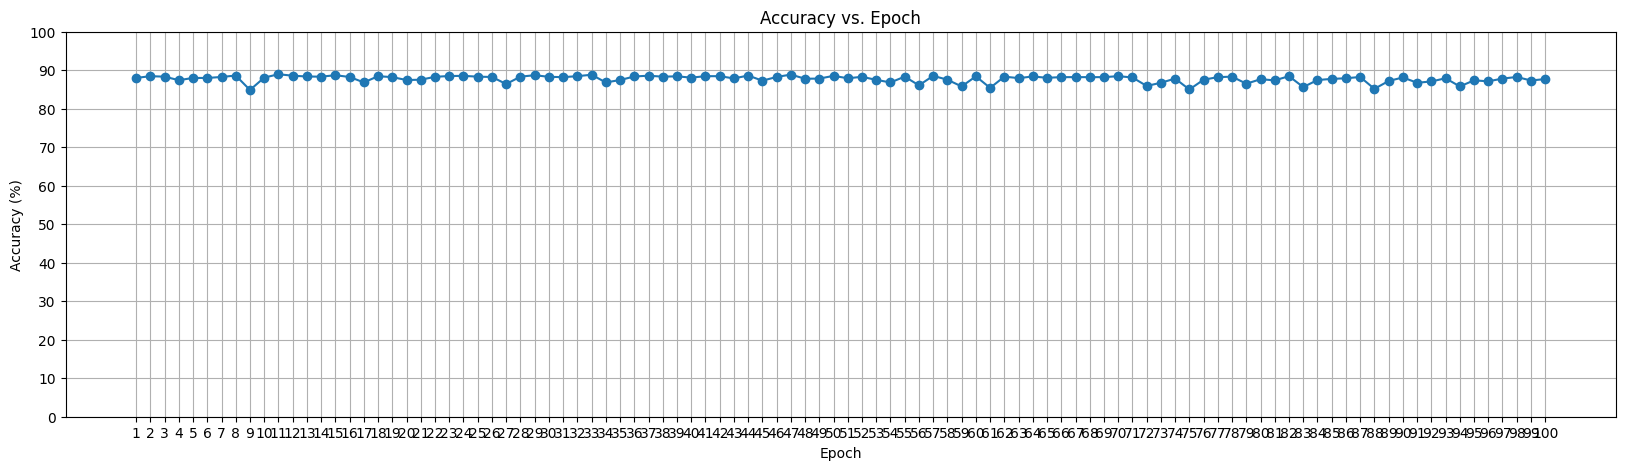

Epoch 1: Accuracy: 89.32888703626512%
Epoch 2: Accuracy: 89.45393914130888%
Epoch 3: Accuracy: 89.87077949145477%
Epoch 4: Accuracy: 90.24593580658608%
Epoch 5: Accuracy: 89.62067528136724%
Epoch 6: Accuracy: 90.28761984160067%
Epoch 7: Accuracy: 90.37098791162984%
Epoch 8: Accuracy: 90.20425177157149%
Epoch 9: Accuracy: 90.66277615673197%
Epoch 10: Accuracy: 90.70446019174656%
Epoch 11: Accuracy: 90.74614422676115%
Epoch 12: Accuracy: 89.95414756148395%
Epoch 13: Accuracy: 90.62109212171738%
Epoch 14: Accuracy: 90.45435598165902%
Epoch 15: Accuracy: 89.82909545644019%
Epoch 16: Accuracy: 90.41267194664444%
Epoch 17: Accuracy: 89.82909545644019%
Epoch 18: Accuracy: 90.41267194664444%
Epoch 19: Accuracy: 90.74614422676115%
Epoch 20: Accuracy: 90.28761984160067%
Epoch 21: Accuracy: 89.82909545644019%
Epoch 22: Accuracy: 90.74614422676115%
Epoch 23: Accuracy: 90.5794080867028%
Epoch 24: Accuracy: 90.28761984160067%
Epoch 25: Accuracy: 89.91246352646937%
Epoch 26: Accuracy: 89.495623176323

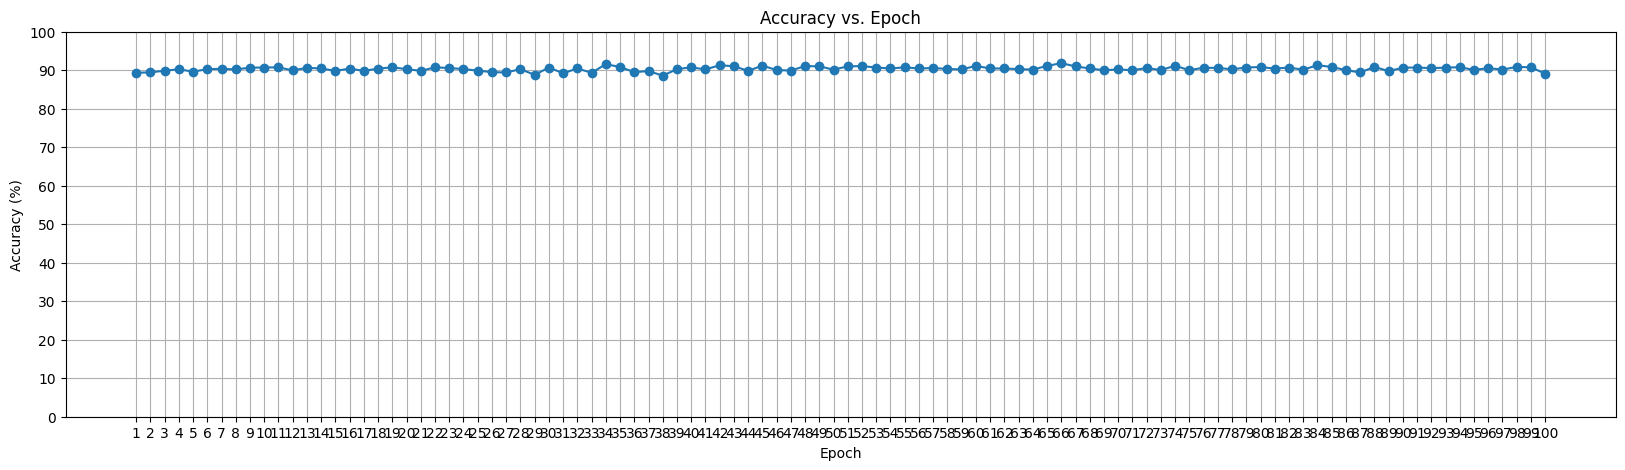

Epoch 1: Accuracy: 86.70279283034598%
Epoch 2: Accuracy: 87.45310546060858%
Epoch 3: Accuracy: 87.53647353063776%
Epoch 4: Accuracy: 87.411421425594%
Epoch 5: Accuracy: 87.411421425594%
Epoch 6: Accuracy: 87.32805335556482%
Epoch 7: Accuracy: 87.20300125052105%
Epoch 8: Accuracy: 87.7865777407253%
Epoch 9: Accuracy: 87.24468528553564%
Epoch 10: Accuracy: 87.57815756565236%
Epoch 11: Accuracy: 88.07836598582743%
Epoch 12: Accuracy: 87.99499791579825%
Epoch 13: Accuracy: 88.07836598582743%
Epoch 14: Accuracy: 88.41183826594414%
Epoch 15: Accuracy: 87.16131721550646%
Epoch 16: Accuracy: 87.24468528553564%
Epoch 17: Accuracy: 88.49520633597332%
Epoch 18: Accuracy: 88.32847019591496%
Epoch 19: Accuracy: 88.12005002084202%
Epoch 20: Accuracy: 88.91204668611921%
Epoch 21: Accuracy: 88.82867861609003%
Epoch 22: Accuracy: 88.24510212588578%
Epoch 23: Accuracy: 88.91204668611921%
Epoch 24: Accuracy: 88.32847019591496%
Epoch 25: Accuracy: 88.32847019591496%
Epoch 26: Accuracy: 88.37015423092956%


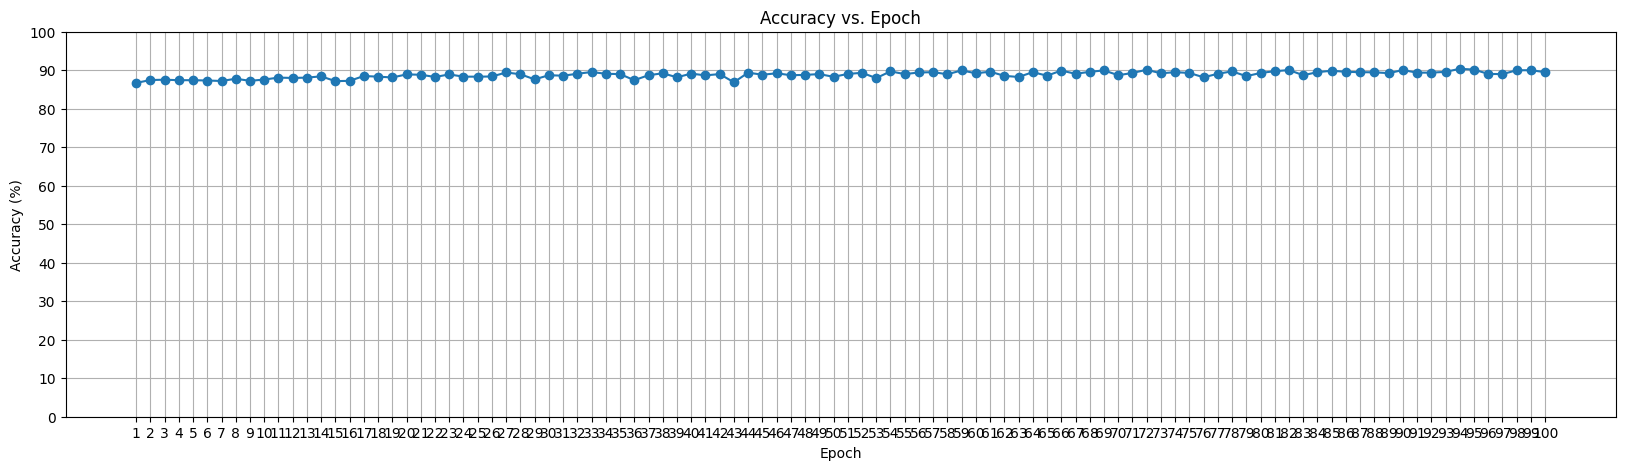

Epoch 1: Accuracy: 87.99499791579825%
Epoch 2: Accuracy: 86.36932055022926%
Epoch 3: Accuracy: 88.12005002084202%
Epoch 4: Accuracy: 87.91162984576907%
Epoch 5: Accuracy: 88.16173405585661%
Epoch 6: Accuracy: 87.99499791579825%
Epoch 7: Accuracy: 86.11921634014172%
Epoch 8: Accuracy: 88.5368903709879%
Epoch 9: Accuracy: 88.78699458107545%
Epoch 10: Accuracy: 88.87036265110463%
Epoch 11: Accuracy: 88.45352230095874%
Epoch 12: Accuracy: 88.32847019591496%
Epoch 13: Accuracy: 88.5785744060025%
Epoch 14: Accuracy: 87.70320967069613%
Epoch 15: Accuracy: 88.49520633597332%
Epoch 16: Accuracy: 88.5785744060025%
Epoch 17: Accuracy: 84.53522300958733%
Epoch 18: Accuracy: 88.16173405585661%
Epoch 19: Accuracy: 88.82867861609003%
Epoch 20: Accuracy: 88.5785744060025%
Epoch 21: Accuracy: 88.66194247603168%
Epoch 22: Accuracy: 88.5368903709879%
Epoch 23: Accuracy: 85.49395581492288%
Epoch 24: Accuracy: 86.07753230512714%
Epoch 25: Accuracy: 88.95373072113381%
Epoch 26: Accuracy: 88.66194247603168%


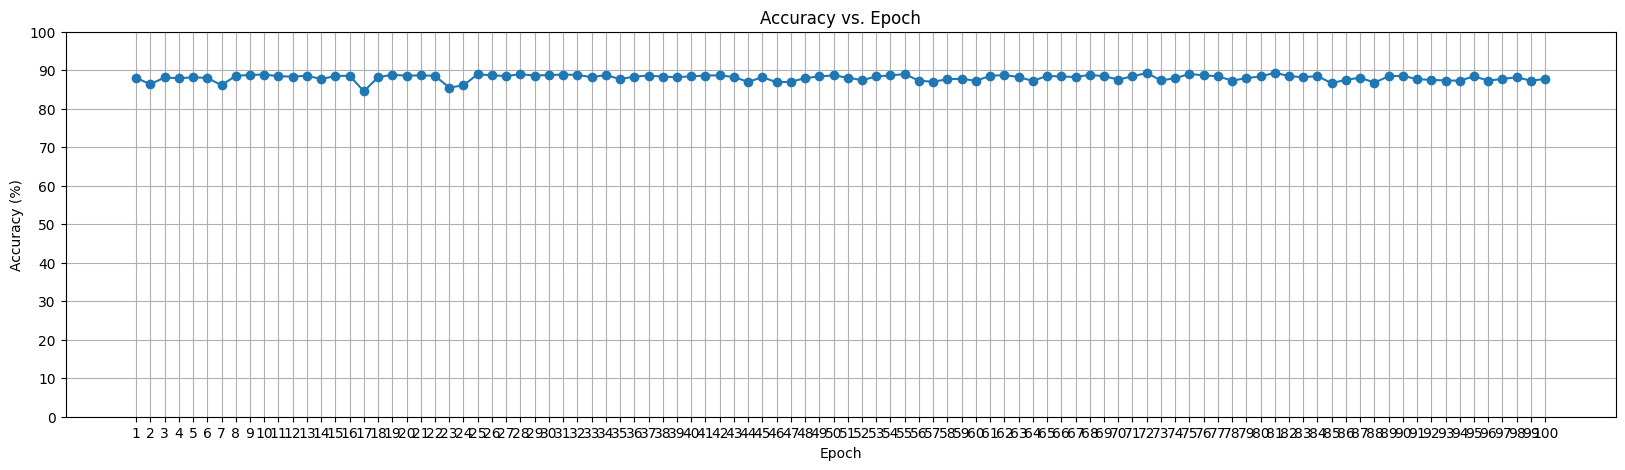

Epoch 1: Accuracy: 87.82826177573989%
Epoch 2: Accuracy: 87.82826177573989%
Epoch 3: Accuracy: 87.95331388078365%
Epoch 4: Accuracy: 87.86994581075449%
Epoch 5: Accuracy: 87.86994581075449%
Epoch 6: Accuracy: 88.16173405585661%
Epoch 7: Accuracy: 87.91162984576907%
Epoch 8: Accuracy: 87.66152563568153%
Epoch 9: Accuracy: 87.99499791579825%
Epoch 10: Accuracy: 87.82826177573989%
Epoch 11: Accuracy: 87.66152563568153%
Epoch 12: Accuracy: 87.7865777407253%
Epoch 13: Accuracy: 87.74489370571071%
Epoch 14: Accuracy: 88.99541475614839%
Epoch 15: Accuracy: 87.86994581075449%
Epoch 16: Accuracy: 87.74489370571071%
Epoch 17: Accuracy: 87.7865777407253%
Epoch 18: Accuracy: 89.32888703626512%
Epoch 19: Accuracy: 87.28636932055024%
Epoch 20: Accuracy: 87.53647353063776%
Epoch 21: Accuracy: 87.11963318049187%
Epoch 22: Accuracy: 87.86994581075449%
Epoch 23: Accuracy: 87.7865777407253%
Epoch 24: Accuracy: 87.66152563568153%
Epoch 25: Accuracy: 86.91121300541893%
Epoch 26: Accuracy: 87.53647353063776

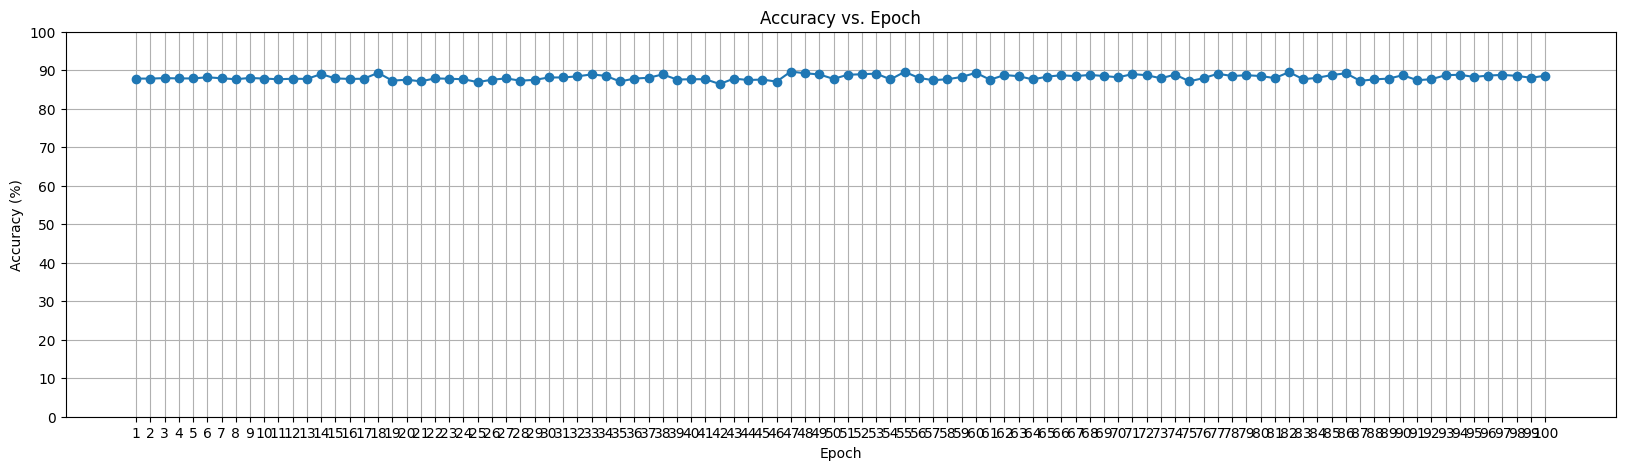

In [35]:
models = {}
for genre in genres:
    y_genre = (data_df['genre'] == genre).astype(int).values  # Create binary labels for this genre
    model = MLP(input_dim=X.shape[1], output_dim=8)  # Output dim is 1 for binary classification
    model.to(device)
    train_loader, test_loader = create_loaders(X, y_genre)  # Use the correct labels here
    
    accuracy = train_model(model, train_loader, test_loader, device)
    models[genre] = model


In [36]:
import torch
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader, TensorDataset
import pandas as pd
import numpy as np

# Load and prepare data
# data_df = pd.read_csv(train_path)  # Assuming data_df is already loaded
# X = data_df.drop('genre', axis=1).values
y = pd.factorize(data_df['genre'])[0]  # Convert genre to numerical labels

# # Scale features
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X)

# X_tensor = torch.tensor(X_scaled, dtype=torch.float32)
# y_tensor=  torch.tensor(y, dtype=torch.long)
# train_full_tensor= TensorDataset(X_tensor, y_tensor)
# train_full_loader= DataLoader(train_full_tensor,batch_size=128,shuffle=False)
# # Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Create DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


Training and evaluating model for: Hip-Hop
Epoch 1: Accuracy: 13.54731137974156%
Epoch 2: Accuracy: 14.21425593997499%
Epoch 3: Accuracy: 16.34014172571905%
Epoch 4: Accuracy: 25.802417674030846%
Epoch 5: Accuracy: 31.26302626094206%
Epoch 6: Accuracy: 32.51354731137974%
Epoch 7: Accuracy: 34.972905377240515%
Epoch 8: Accuracy: 37.30721133805753%
Epoch 9: Accuracy: 39.182992913714045%
Epoch 10: Accuracy: 42.350979574822844%
Epoch 11: Accuracy: 41.64235097957482%
Epoch 12: Accuracy: 43.05960817007086%
Epoch 13: Accuracy: 44.22676115047937%
Epoch 14: Accuracy: 45.60233430596082%
Epoch 15: Accuracy: 45.64401834097541%
Epoch 16: Accuracy: 45.560650270946226%
Epoch 17: Accuracy: 45.93580658607753%
Epoch 18: Accuracy: 45.22717799082951%
Epoch 19: Accuracy: 47.102959566486035%
Epoch 20: Accuracy: 46.4360150062526%
Epoch 21: Accuracy: 46.68611921634014%
Epoch 22: Accuracy: 49.97915798249271%
Epoch 23: Accuracy: 48.770320967069615%
Epoch 24: Accuracy: 47.97832430179241%
Epoch 25: Accuracy: 49.2

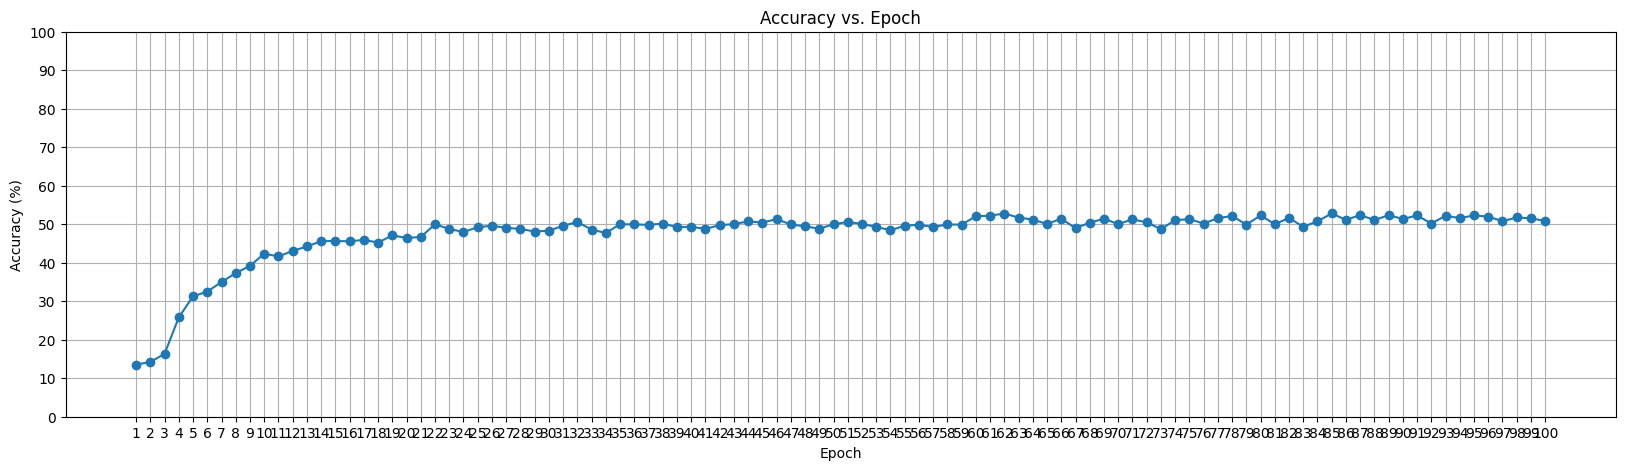

Max Accuracy for Hip-Hop: 52.813672363484784%
Training and evaluating model for: Pop
Epoch 1: Accuracy: 14.464360150062525%
Epoch 2: Accuracy: 15.131304710295957%
Epoch 3: Accuracy: 15.172988745310546%
Epoch 4: Accuracy: 28.42851187994998%
Epoch 5: Accuracy: 32.6802834514381%
Epoch 6: Accuracy: 32.72196748645269%
Epoch 7: Accuracy: 38.93288870362651%
Epoch 8: Accuracy: 38.34931221342226%
Epoch 9: Accuracy: 42.392663609837435%
Epoch 10: Accuracy: 41.76740308461859%
Epoch 11: Accuracy: 43.434764485202166%
Epoch 12: Accuracy: 44.435181325552314%
Epoch 13: Accuracy: 43.10129220508545%
Epoch 14: Accuracy: 45.68570237599%
Epoch 15: Accuracy: 45.85243851604835%
Epoch 16: Accuracy: 46.4360150062526%
Epoch 17: Accuracy: 47.31137974155898%
Epoch 18: Accuracy: 47.35306377657357%
Epoch 19: Accuracy: 47.89495623176323%
Epoch 20: Accuracy: 47.68653605669029%
Epoch 21: Accuracy: 48.020008336807%
Epoch 22: Accuracy: 48.770320967069615%
Epoch 23: Accuracy: 49.228845352230096%
Epoch 24: Accuracy: 48.645

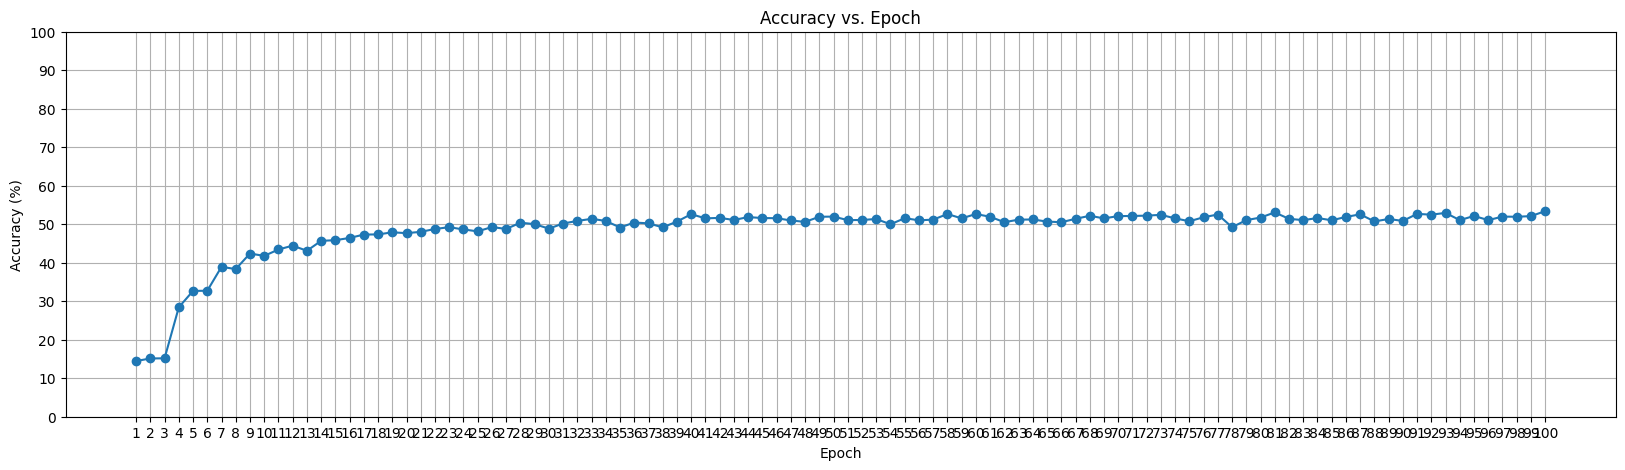

Max Accuracy for Pop: 53.397248853689035%
Training and evaluating model for: Folk
Epoch 1: Accuracy: 12.505210504376823%
Epoch 2: Accuracy: 13.755731554814506%
Epoch 3: Accuracy: 22.467694872863692%
Epoch 4: Accuracy: 27.261358899541477%
Epoch 5: Accuracy: 33.430596081700706%
Epoch 6: Accuracy: 39.84993747394748%
Epoch 7: Accuracy: 43.017924135056276%
Epoch 8: Accuracy: 43.14297624010004%
Epoch 9: Accuracy: 44.1017090454356%
Epoch 10: Accuracy: 44.393497290537724%
Epoch 11: Accuracy: 47.102959566486035%
Epoch 12: Accuracy: 45.31054606085869%
Epoch 13: Accuracy: 45.85243851604835%
Epoch 14: Accuracy: 47.47811588161734%
Epoch 15: Accuracy: 48.10337640683618%
Epoch 16: Accuracy: 45.85243851604835%
Epoch 17: Accuracy: 48.686952897040435%
Epoch 18: Accuracy: 48.020008336807%
Epoch 19: Accuracy: 48.93705710712797%
Epoch 20: Accuracy: 46.89453939141309%
Epoch 21: Accuracy: 49.81242184243435%
Epoch 22: Accuracy: 48.85368903709879%
Epoch 23: Accuracy: 47.72822009170488%
Epoch 24: Accuracy: 47.6

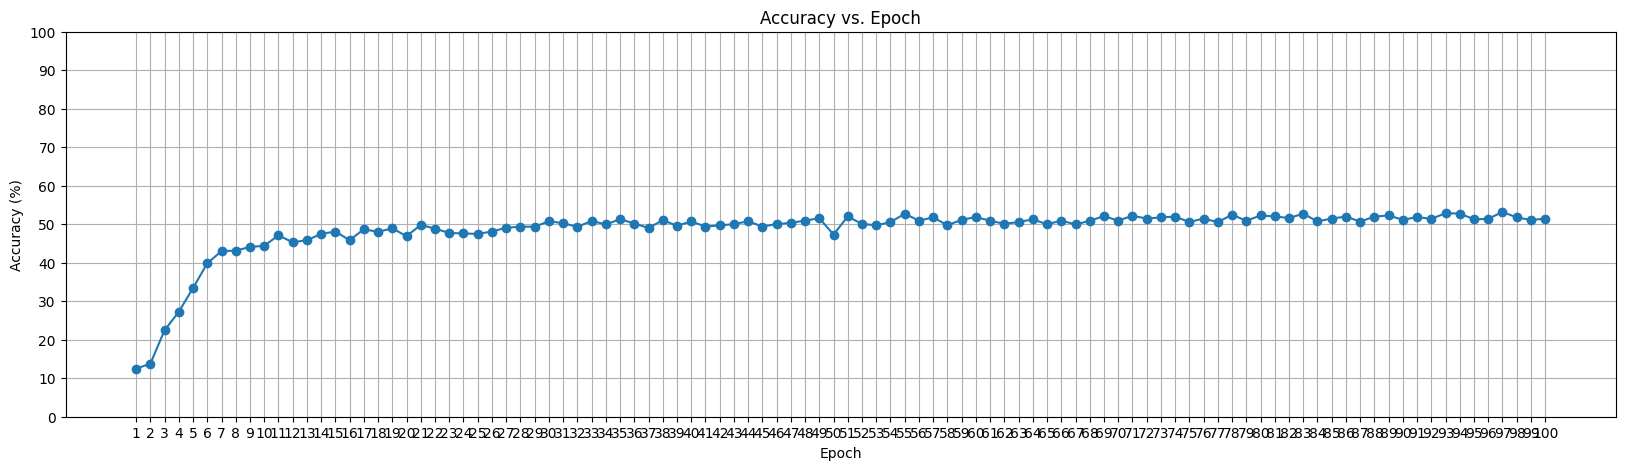

Max Accuracy for Folk: 53.18882867861609%
Training and evaluating model for: Experimental
Epoch 1: Accuracy: 13.755731554814506%
Epoch 2: Accuracy: 13.755731554814506%
Epoch 3: Accuracy: 19.21634014172572%
Epoch 4: Accuracy: 27.803251354731138%
Epoch 5: Accuracy: 30.429345560650273%
Epoch 6: Accuracy: 33.55564818674448%
Epoch 7: Accuracy: 37.55731554814506%
Epoch 8: Accuracy: 41.267194664443515%
Epoch 9: Accuracy: 42.47603167986661%
Epoch 10: Accuracy: 43.22634431012922%
Epoch 11: Accuracy: 45.22717799082951%
Epoch 12: Accuracy: 45.39391413088787%
Epoch 13: Accuracy: 45.560650270946226%
Epoch 14: Accuracy: 47.102959566486035%
Epoch 15: Accuracy: 46.93622342642768%
Epoch 16: Accuracy: 47.2696957065444%
Epoch 17: Accuracy: 49.97915798249271%
Epoch 18: Accuracy: 48.8120050020842%
Epoch 19: Accuracy: 46.81117132138391%
Epoch 20: Accuracy: 47.186327636515216%
Epoch 21: Accuracy: 48.603584827011254%
Epoch 22: Accuracy: 48.770320967069615%
Epoch 23: Accuracy: 47.85327219674865%
Epoch 24: Accu

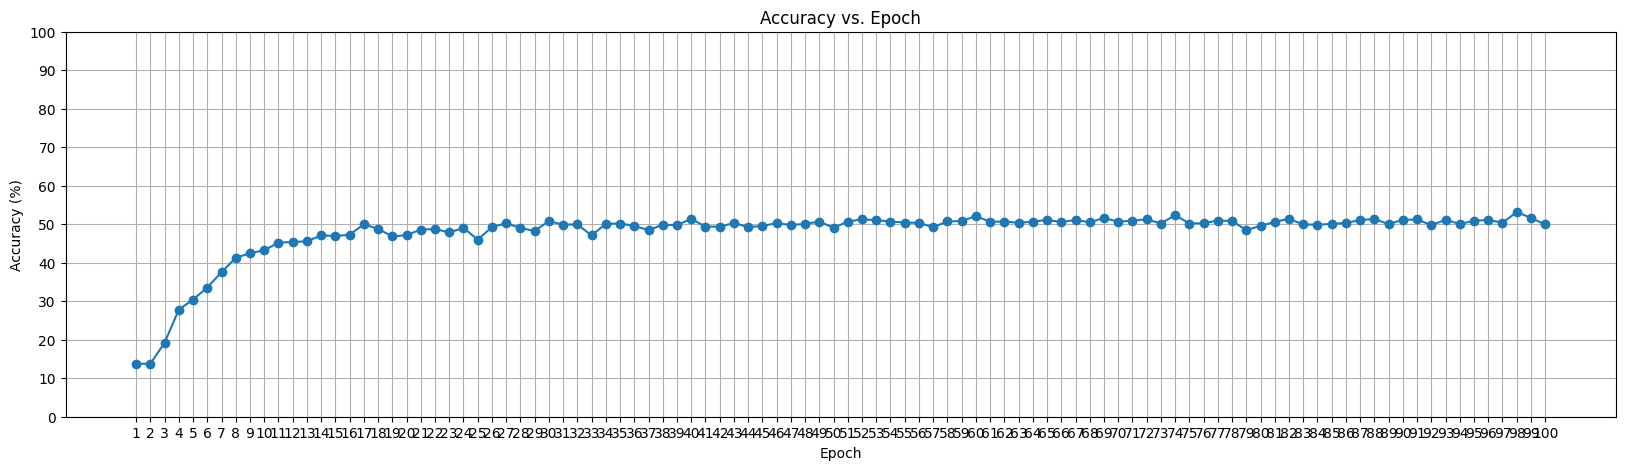

Max Accuracy for Experimental: 53.1471446436015%
Training and evaluating model for: Rock
Epoch 1: Accuracy: 13.672363484785327%
Epoch 2: Accuracy: 13.880783659858274%
Epoch 3: Accuracy: 14.255939974989579%
Epoch 4: Accuracy: 26.21925802417674%
Epoch 5: Accuracy: 33.430596081700706%
Epoch 6: Accuracy: 35.8065860775323%
Epoch 7: Accuracy: 38.01583993330554%
Epoch 8: Accuracy: 35.93163818257607%
Epoch 9: Accuracy: 39.30804501875782%
Epoch 10: Accuracy: 40.97540641934139%
Epoch 11: Accuracy: 41.97582325969154%
Epoch 12: Accuracy: 44.935389745727385%
Epoch 13: Accuracy: 43.26802834514381%
Epoch 14: Accuracy: 46.35264693622343%
Epoch 15: Accuracy: 46.602751146310965%
Epoch 16: Accuracy: 47.019591496456854%
Epoch 17: Accuracy: 44.01834097540642%
Epoch 18: Accuracy: 45.81075448103376%
Epoch 19: Accuracy: 46.93622342642768%
Epoch 20: Accuracy: 48.47853272196749%
Epoch 21: Accuracy: 47.39474781158816%
Epoch 22: Accuracy: 49.6040016673614%
Epoch 23: Accuracy: 46.93622342642768%
Epoch 24: Accuracy

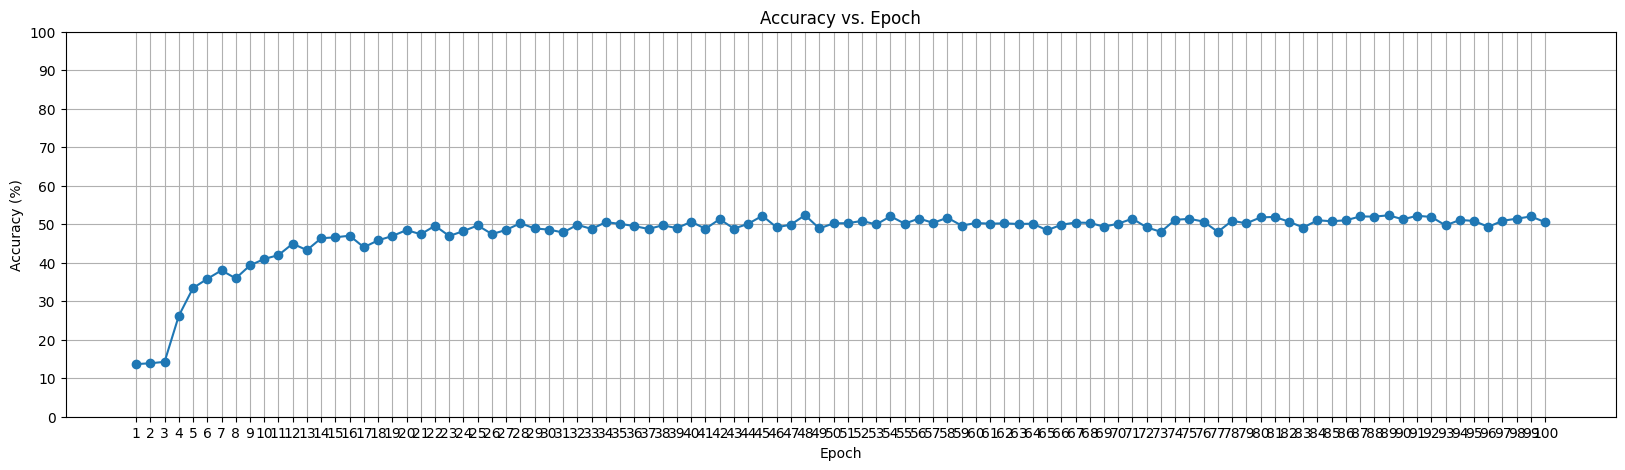

Max Accuracy for Rock: 52.355147978324304%
Training and evaluating model for: International
Epoch 1: Accuracy: 13.54731137974156%
Epoch 2: Accuracy: 13.672363484785327%
Epoch 3: Accuracy: 15.089620675281367%
Epoch 4: Accuracy: 26.552730304293455%
Epoch 5: Accuracy: 34.22259274697791%
Epoch 6: Accuracy: 38.766152563568156%
Epoch 7: Accuracy: 39.80825343893289%
Epoch 8: Accuracy: 44.435181325552314%
Epoch 9: Accuracy: 45.35223009587328%
Epoch 10: Accuracy: 47.102959566486035%
Epoch 11: Accuracy: 45.93580658607753%
Epoch 12: Accuracy: 48.22842851187995%
Epoch 13: Accuracy: 48.020008336807%
Epoch 14: Accuracy: 47.51979991663193%
Epoch 15: Accuracy: 48.97874114214256%
Epoch 16: Accuracy: 50.02084201750729%
Epoch 17: Accuracy: 48.4368486869529%
Epoch 18: Accuracy: 49.6040016673614%
Epoch 19: Accuracy: 49.6040016673614%
Epoch 20: Accuracy: 50.02084201750729%
Epoch 21: Accuracy: 48.93705710712797%
Epoch 22: Accuracy: 48.020008336807%
Epoch 23: Accuracy: 48.645268862025844%
Epoch 24: Accuracy: 

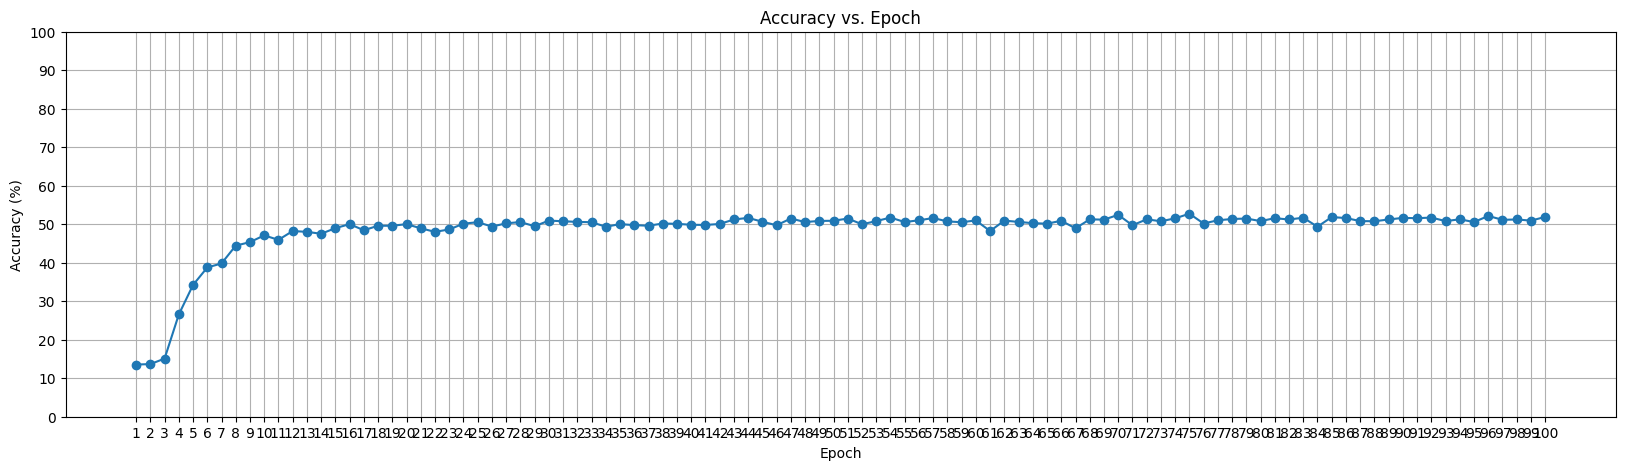

Max Accuracy for International: 52.7303042934556%
Training and evaluating model for: Electronic
Epoch 1: Accuracy: 13.338891204668611%
Epoch 2: Accuracy: 13.880783659858274%
Epoch 3: Accuracy: 22.71779908295123%
Epoch 4: Accuracy: 26.177573989162152%
Epoch 5: Accuracy: 29.887453105460608%
Epoch 6: Accuracy: 33.13880783659858%
Epoch 7: Accuracy: 37.640683618174236%
Epoch 8: Accuracy: 40.766986244268445%
Epoch 9: Accuracy: 40.35014589412255%
Epoch 10: Accuracy: 41.01709045435598%
Epoch 11: Accuracy: 41.01709045435598%
Epoch 12: Accuracy: 45.76907044601918%
Epoch 13: Accuracy: 45.93580658607753%
Epoch 14: Accuracy: 45.68570237599%
Epoch 15: Accuracy: 45.39391413088787%
Epoch 16: Accuracy: 46.39433097123801%
Epoch 17: Accuracy: 47.51979991663193%
Epoch 18: Accuracy: 47.35306377657357%
Epoch 19: Accuracy: 48.645268862025844%
Epoch 20: Accuracy: 47.68653605669029%
Epoch 21: Accuracy: 48.35348061692372%
Epoch 22: Accuracy: 48.4368486869529%
Epoch 23: Accuracy: 48.31179658190913%
Epoch 24: Acc

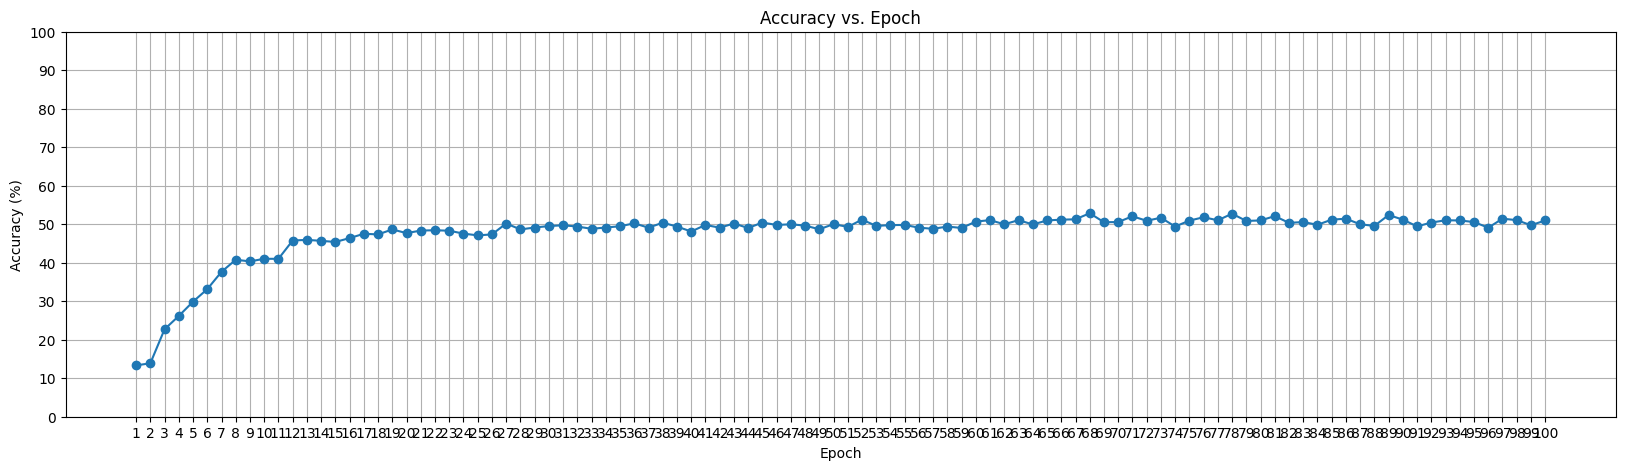

Max Accuracy for Electronic: 52.855356398499374%
Training and evaluating model for: Instrumental
Epoch 1: Accuracy: 13.672363484785327%
Epoch 2: Accuracy: 13.255523134639432%
Epoch 3: Accuracy: 13.922467694872864%
Epoch 4: Accuracy: 27.09462275948312%
Epoch 5: Accuracy: 32.888703626511045%
Epoch 6: Accuracy: 37.59899958315965%
Epoch 7: Accuracy: 41.05877448937057%
Epoch 8: Accuracy: 42.60108378491038%
Epoch 9: Accuracy: 43.76823676531888%
Epoch 10: Accuracy: 43.3097123801584%
Epoch 11: Accuracy: 45.018757815756565%
Epoch 12: Accuracy: 45.2688620258441%
Epoch 13: Accuracy: 45.68570237599%
Epoch 14: Accuracy: 47.061275531471445%
Epoch 15: Accuracy: 48.145060441850774%
Epoch 16: Accuracy: 46.10254272613589%
Epoch 17: Accuracy: 46.35264693622343%
Epoch 18: Accuracy: 47.43643184660275%
Epoch 19: Accuracy: 50.06252605252188%
Epoch 20: Accuracy: 48.728636932055025%
Epoch 21: Accuracy: 48.31179658190913%
Epoch 22: Accuracy: 48.603584827011254%
Epoch 23: Accuracy: 47.72822009170488%
Epoch 24: A

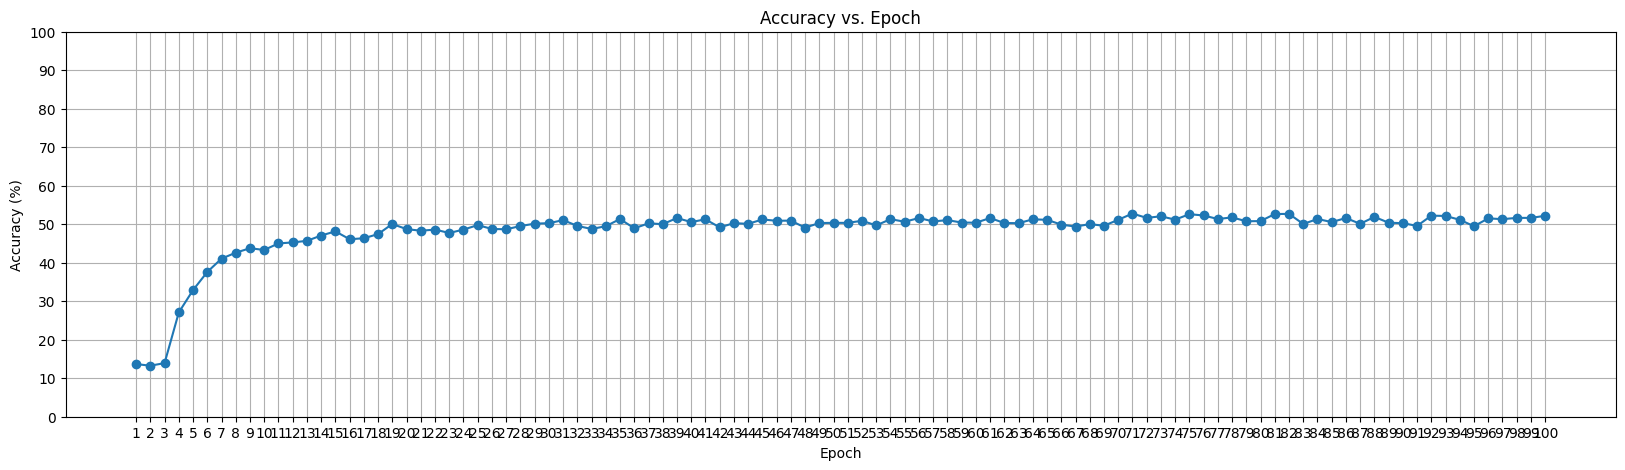

Max Accuracy for Instrumental: 52.771988328470194%


In [37]:


model_performances = {}
for genre, model in models.items():
    model.to(device)
    print(f"Training and evaluating model for: {genre}")
    max_accuracy = train_model(model, train_loader, test_loader, device)
    model_performances[genre] = max_accuracy
    print(f"Max Accuracy for {genre}: {max_accuracy}%")

In [38]:
def combine_predictions(models, test_loader, device):
    total_probs = None
    for model in models.values():
        model.to(device)
        model.eval()
        all_outputs = []
        with torch.no_grad():
            for inputs, _ in test_loader:
                inputs = inputs.to(device)
                outputs = torch.softmax(model(inputs), dim=1)
                all_outputs.append(outputs)
        probs = torch.cat(all_outputs, dim=0)
        if total_probs is None:
            total_probs = probs / len(models)
        else:
            total_probs += probs / len(models)

    _, combined_predictions = torch.max(total_probs, dim=1)
    return combined_predictions

combined_predictions = combine_predictions(models, test_loader, device)


In [39]:
from sklearn.metrics import accuracy_score

combined_predictions = combined_predictions.cpu().numpy()
accuracy = accuracy_score(y_test, combined_predictions)
print("Combined Model Accuracy:", accuracy)


Combined Model Accuracy: 0.5518966235931638


In [40]:
print(classification_report(y_test, combined_predictions, target_names=list(models.keys())))


               precision    recall  f1-score   support

      Hip-Hop       0.64      0.63      0.63       330
          Pop       0.36      0.38      0.37       282
         Folk       0.55      0.71      0.62       294
 Experimental       0.49      0.46      0.47       288
         Rock       0.64      0.65      0.64       299
International       0.62      0.65      0.63       327
   Electronic       0.53      0.41      0.46       289
 Instrumental       0.56      0.49      0.52       290

     accuracy                           0.55      2399
    macro avg       0.55      0.55      0.55      2399
 weighted avg       0.55      0.55      0.55      2399



In [41]:


# Assuming X_train.shape[1] is defined and device is defined
dummy_input = torch.zeros(1,X_train.shape[1]).to(device)  # Move dummy_input to the same device as the model
model.to(device)

# Visualize the model using torchviz
model_vis = make_dot(model(dummy_input), params=dict(model.named_parameters()))
model_vis.render("neural_network_visualization_model", format="png", view=True)

# Assuming num_classes is defined
summary(model, input_size=dummy_input.size()[1:])  # Correctly specifying input_size as a tuple


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
       BatchNorm1d-1                 [-1, 1185]           2,370
            Linear-2                 [-1, 2048]       2,428,928
       BatchNorm1d-3                 [-1, 2048]           4,096
         LeakyReLU-4                 [-1, 2048]               0
           Dropout-5                 [-1, 2048]               0
            Linear-6                 [-1, 1024]       2,098,176
         LeakyReLU-7                 [-1, 1024]               0
           Dropout-8                 [-1, 1024]               0
            Linear-9                  [-1, 512]         524,800
      BatchNorm1d-10                  [-1, 512]           1,024
        LeakyReLU-11                  [-1, 512]               0
          Dropout-12                  [-1, 512]               0
           Linear-13                  [-1, 256]         131,328
      BatchNorm1d-14                  [